# ArcGIS API for Python: AIS Route Extraction Prototype

## A collaboration between the U.S. Department of Transportation and Esri

###### Alberto Nieto (Esri), Andrew Barrows (USDOT), Dominic Menegus (USDOT)

This Jupyter Notebook contains documentation, processing, and data visualization of a prototype process in which the Automated Identification System (AIS) vessel data for specified terminal-to-terminal connections is used to digitize a route polyline dataset for an authoritative GIS. 

This process can be leveraged to develop an Information Product that generates data-driven ferry routes for all terminals in the United States, and could be extended to other environments and use cases.

Contact Info:
anieto@esri.com

# Setup

#### Script Set-up (Imports, variables, etc.) (Pre-process)

In [ ]:
import arcgis
import plotly
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline  

gis = arcgis.gis.GIS()

In [ ]:
gis_app_id = r"wt3QUR1M4eum0TVI"
gis_url = r"https://esrifederal.maps.arcgis.com"
gis = arcgis.gis.GIS(gis_url, client_id=gis_app_id)

#### Code to run and plot lowess on AIS Staten Island sample (Pre-processed)

In [ ]:
def calculate_lat_lon_in_spatialdf(spatialdf, shape_field='SHAPE', output_lat='latitude', output_lon='longitude'):

    def calculate_latitude(shape_field):
        return shape_field['y']

    def calculate_longitude(shape_field):
        return shape_field['x']

    # Calculate latitude and longitude fields from the shape attribute
    spatialdf[output_lat] = spatialdf.apply(lambda x: calculate_latitude(x[shape_field]), axis=1)
    spatialdf[output_lon] = spatialdf.apply(lambda x: calculate_longitude(x[shape_field]), axis=1)

    return spatialdf

In [ ]:
# ais_local_fgdb = r"D:\ANieto_SolutionEngineer\Data\DOT\BTS\Zone18_2014_07\Zone18_2014_07.gdb"
# ais_sample_fc = "C:\\Users\\albe9057\\Documents\\ANieto_SolutionEngineering\\Projects\\FedGIS\\FedGIS_2018\\Zone18_2014_07.gdb\\AIS_Sampler"
# ais_sdf = calculate_lat_lon_in_spatialdf(arcgis.features.SpatialDataFrame.from_featureclass(ais_sample_fc))
# ais_sdf

In [ ]:
ais_sample = gis.content.search("AIS_StatenIsland_Sample", item_type="feature layer")[0]
ais_sample

In [ ]:
ais_sample_df = arcgis.features.SpatialDataFrame.from_layer(ais_sample.layers[0])
ais_sample_df

In [ ]:
ais_sdf = calculate_lat_lon_in_spatialdf(ais_sample_df)
ais_sdf

##### Run lowess using Staten Island AIS sample (Pre-processed)

In [ ]:
lowess = sm.nonparametric.lowess
lowess_ais = lowess(ais_sdf['latitude'], ais_sdf['longitude'])

# Ask Questions

### How can we determine "average" paths for ferry routes in the United States? 

# Proposed Methodology

#### Use AIS positional data to determine ship positions along routes, perform qualitative checks, and digitize polyline geometry

<img src="../../docs/dbclustering.PNG"></img>

# Part 1: Retrieve and Explore AIS Data

#### Code to Retrieve AIS Data

In [14]:
ais_sample = gis.content.search("AIS_StatenIsland_Sample", item_type="feature layer")[0]
ais_sample

<Item title:"AIS_StatenIsland_Sample" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>

#### Map of AIS Data

In [15]:
nyc_map = gis.map("-74.193765, 40.667519", zoomlevel=10)
nyc_map.add_layer(ais_sample)
nyc_map.basemap = 'streets-night-vector'
nyc_map

<!-- <img src="img/capture05.png"> -->

# Part 2: Run Lowess

### Explanation of Loess/Lowess

Locally Weighted Scatterplot (LOWESS) Basic Facts:

- Used in regression analysis to create a smooth line through a scatterplot.

- Has a robust fitting method.  Because of this it can be used when there are noisy data values.

- Non-parametric – no assumptions are made about the shape of the line of fit.

<img src="img/lowess.jpg">

### Plot of First Run of Lowess

In [17]:
plotly.offline.plot({
    "data": [plotly.graph_objs.Scatter(x=ais_sdf['longitude'], y=ais_sdf['latitude'])]
})

'file://C:\\Users\\albe9057\\Documents\\GitHub\\AISFerryRouteDigitization_Prototype\\scripts\\prototype\\temp-plot.html'

<!-- <img src="img/newplot.png"> -->

In [18]:
plotly.plotly.iplot({
    "data": [plotly.graph_objs.Scatter(x=ais_sdf['longitude'], y=ais_sdf['latitude'])]
})

#### Plot Lowess first run

In [19]:
plotly.offline.plot({
    "data": [plotly.graph_objs.Scatter(x=lowess_ais[:,0], y=lowess_ais[:,1])]
})

'file://C:\\Users\\albe9057\\Documents\\GitHub\\AISFerryRouteDigitization_Prototype\\scripts\\prototype\\temp-plot.html'

<!-- <img src="img/newplot1.png"> -->

#### Pre-QC Route Layer on WebMap

<Item title:"AIS_SIFerryRoute_PreQC" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
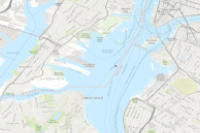

In [20]:
preqc_route_layer = gis.content.search("AIS_SIFerryRoute_PreQC", item_type="feature service")[0]
preqc_route_layer

In [21]:
preqc_route_map = gis.map("Bayonne, NJ", zoomlevel=12)
preqc_route_map.basemap = 'gray'
preqc_route_map.add_layer(ais_sample)
preqc_route_map.add_layer(preqc_route_layer)
preqc_route_map

<!-- <img src="img/capture01.PNG"> -->

#### The north end of the route overshoots the terminal... let's fix this.

# Part 3: Run QC - Density-based Clustering

#### Explanation of Density-based Clustering

http://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/how-density-based-clustering-works.htm

<img src="img/capture02.PNG">

<img src="img/capture03.PNG">

#### Code to Retrieve Density-based Clustering Layers (with noise, and without noise) and Show on Maps

DBSCAN With noise

In [22]:
dbcluster_lyr_full = gis.content.search("OPTICS_AIS_Sampler_50ft_lowsens", item_type="feature service")[1]
dbcluster_map = gis.map("Bayonne, NJ", zoomlevel=12)
dbcluster_map.basemap = "gray"
dbcluster_map.add_layer(dbcluster_lyr_full)
dbcluster_map

<!-- <img src="img/capture04.PNG"> -->

Without noise

In [23]:
dbcluster_lyr_full_nonoise = gis.content.search("OPTICS_AIS_Sampler_50ft_lowsens_FILTER_nonoise")[0]
dbcluster_map = gis.map("Bayonne, NJ", zoomlevel=12)
dbcluster_map.basemap = "gray"
dbcluster_map.add_layer(dbcluster_lyr_full_nonoise)
dbcluster_map

<!-- <img src="img/capture.png"> -->

# Part 4: Post QC - Map

#### Lowess Layer on WebMap

<Item title:"AIS_SIFerryRoute_PostQC" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
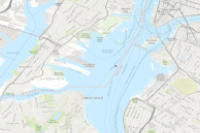

In [24]:
postqc_route_layer = gis.content.search("AIS_SIFerryRoute_PostQC")[0]
postqc_route_layer

In [25]:
postqc_route_map = gis.map("Bayonne, NJ", zoomlevel=12)
postqc_route_map.basemap = 'gray'
postqc_route_map.add_layer(postqc_route_layer)
postqc_route_map

<!-- <img src="img/capture06.png"> -->

### Next Steps

- Continued improvement on generalization function. 
- Iteratation on multiple routes.  
- Output lowess line into geospatial web application. 
- Published authoritative records into <a ref="https://osav-usdot.opendata.arcgis.com/">Bureau of Transportation Open Data site.</a>

### In Conclusion...